In [1]:
import pandas as pd
import xgboost as xgb
import sklearn as sk
import warnings
warnings.filterwarnings("ignore")
from AUTO_ML import data_cleaning, feature_check, autoML, autoPredict

In [2]:
data = pd.read_csv('./Test_Data/Titanic_train.csv')

#### Step One: Clean the dataset

In [7]:
actions_dict = {1: 'drop', 2: 'dummy', 3: 'indicator', 4: 'numeric', 5: 'time', 6: 'later'} # user defined
tar_col = 'Survived'
# set up the cleaning object
s1 = data_cleaning(data, list(set(data.columns)-set([tar_col])), tar_col, actions_dict)
# use start_action function to loop through all the features
action_dict = s1.start_action() 
action_dict

{'Age': '4',
 'Embarked': '2',
 'Fare': '4',
 'Parch': '2',
 'Pclass': '2',
 'Sex': '2',
 'SibSp': '4'}

In [5]:
# action_dict records all the necessary action, now we can clean all of them at once
drop = [i for i in action_dict.keys() if action_dict[i]==str(1)]
dummy = [i for i in action_dict.keys() if action_dict[i]==str(2)]
indicator = [i for i in action_dict.keys() if action_dict[i]==str(3)]
numeric = [i for i in action_dict.keys() if action_dict[i]==str(4)]
time = [i for i in action_dict.keys() if action_dict[i]==str(5)]
later = [i for i in action_dict.keys() if action_dict[i]==str(6)]

data = data.drop(drop,axis=1)
data[numeric] = data[numeric].astype(float)
for ind in indicator:
    data[ind] = np.where(~data[ind].isnull(),1,0)
data = pd.get_dummies(data,columns=dummy,dummy_na=True)
nan_col = []
for i in data.columns:
    if 'nan' in i:
        nan_col.append(i)
data = data.drop(drop+nan_col,axis=1)

#### Step Two: Check data cleaning result

In [6]:
# use check_missing function to check which features have N/A
# returns (dataframe, column name list)
s2 = feature_check(data, 'Survived') # set up checking object
s2.check_missing()[0]

,features,#null
0,Survived,0
1,Age,177
2,SibSp,0
3,Fare,0
4,Embarked_C,0
5,Embarked_Q,0
6,Embarked_S,0
7,Parch_0.0,0
8,Parch_1.0,0
9,Parch_2.0,0


In [7]:
s2.check_missing()[1]

['Age']

In [8]:
s2.check_object()  # check whether there are still object type

True

In [9]:
s2.check_imblance() # check class-balance, we should use smote

0    549
1    342
Name: Survived, dtype: int64

#### Step Three: AUTO ML

In [10]:
s3 = autoML(data, 'Survived') # set up auto ML object
s3.split() # split the dataset into train and test
# can use s3.train to check train set
# s3.test to check test set, you can also define your own

In [23]:
# grid-search on k-fold to find the best hyper-parameters

grid_serach = {'max_depth': [1, 3, 5, 7, 9],
 'colsample_bytree': [0.1, 0.3, 0.5, 0.7],
 'n_estimators': [10, 30, 50 ,100]} # the grid_search range

# you can define your own filler such as {'Age': 30}
fill_method = 'mean' # how you want to fill the missing values

# return (grid_search_dictionary, the highest score, the lowest score)
result = s3.cross_validation(fold=5, 
                             col = list(set(data.columns)-set(['Survived'])), 
                            model = xgb.XGBClassifier, 
                            params=grid_serach, 
                            scorer=sk.metrics.roc_auc_score, # we use roc for classification
                            fill_method = fill_method, 
                            fkbest=[5,6,7,8,9,10,11,12,13,14],  # feature selection using f-statistics 
                            scaling = True, 
                            smote=True, 
                            classification=True)

In [24]:
result[0]

{(1, 0.1, 10, 5): 0.8363788388005758,
 (1, 0.1, 30, 5): 0.8361046704644071,
 (1, 0.1, 50, 5): 0.8361303021219214,
 (1, 0.1, 100, 5): 0.8364377384921255,
 (1, 0.3, 10, 5): 0.8359021636283135,
 (1, 0.3, 30, 5): 0.8359602486086256,
 (1, 0.3, 50, 5): 0.8361836581202535,
 (1, 0.3, 100, 5): 0.8385309957948529,
 (1, 0.5, 10, 5): 0.8293298421172594,
 (1, 0.5, 30, 5): 0.8357998709995063,
 (1, 0.5, 50, 5): 0.836658003647136,
 (1, 0.5, 100, 5): 0.8356525850059239,
 (1, 0.7, 10, 5): 0.8254904516309278,
 (1, 0.7, 30, 5): 0.834032774559249,
 (1, 0.7, 50, 5): 0.8361246986921849,
 (1, 0.7, 100, 5): 0.8338774254124637,
 (3, 0.1, 10, 5): 0.8361150558560121,
 (3, 0.1, 30, 5): 0.8380607386631052,
 (3, 0.1, 50, 5): 0.8407979912117248,
 (3, 0.1, 100, 5): 0.8402213485277494,
 (3, 0.3, 10, 5): 0.837026852362675,
 (3, 0.3, 30, 5): 0.8359118786523829,
 (3, 0.3, 50, 5): 0.836003368888387,
 (3, 0.3, 100, 5): 0.8406338736831602,
 (3, 0.5, 10, 5): 0.8417216913712704,
 (3, 0.5, 30, 5): 0.8456204093382869,
 (3, 0.5, 

In [25]:
result[1] # the best parameters

((9, 0.5, 30, 13), 0.8696401211199174)

In [26]:
result[2]

((1, 0.1, 10, 9), 0.7694719466960532)

The score is 0.8413328294280676


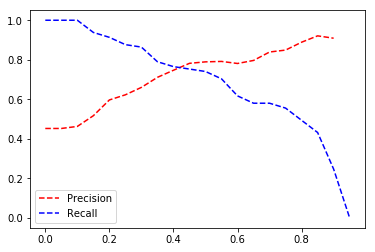

In [11]:
# retrain on the whole trainset and test on the testset
# automatically plot the precision and recall line
# return (model, prediction)
best_params = {'max_depth': [9],
 'colsample_bytree': [0.5],
 'n_estimators': [30]}
fill_method = 'mean'

result = s3.predict_test(col = list(set(data.columns)-set(['Survived'])), 
                        model = xgb.XGBClassifier, 
                        best_params=best_params, 
                        scorer=sk.metrics.roc_auc_score,
                        fill_method = fill_method, fkbest=13, 
                        scaling = True, smote=True, classification=True)

In [12]:
result[0]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=30, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

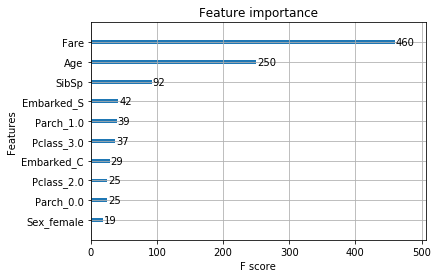

In [14]:
xgb.plot_importance(result[0],max_num_features=10)

In [13]:
result[1]

array([0.94296676, 0.5244092 , 0.85130465, 0.18361871, 0.22518167,
       0.28160203, 0.9462566 , 0.94296676, 0.3183699 , 0.14861561,
       0.9462634 , 0.13691796, 0.5605208 , 0.8575702 , 0.92410445,
       0.9330431 , 0.27681717, 0.9411449 , 0.9143495 , 0.9423504 ,
       0.33686262, 0.11747371, 0.18283363, 0.59663284, 0.13198924,
       0.39182442, 0.29277924, 0.12362538, 0.8128455 , 0.11933529,
       0.56041086, 0.1431409 , 0.38899103, 0.8993904 , 0.38586506,
       0.6102641 , 0.49577594, 0.19200924, 0.15424411, 0.8128455 ,
       0.1756095 , 0.20405957, 0.68857527, 0.15664826, 0.34666032,
       0.90981156, 0.1429716 , 0.11602748, 0.3394989 , 0.21165465,
       0.15789485, 0.14661925, 0.3776231 , 0.60357124, 0.88646895,
       0.11747371, 0.18361871, 0.1466879 , 0.8001288 , 0.8899028 ,
       0.29277924, 0.9118402 , 0.55506635, 0.945426  , 0.8724558 ,
       0.5598299 , 0.5355829 , 0.5206222 , 0.21590936, 0.19077517,
       0.8146072 , 0.88412154, 0.83321667, 0.2518631 , 0.57098

In [15]:
# retrain on the whole dataset and wait for the real-test set in practice
s3.final_product(col = list(set(data.columns)-set(['Survived'])), 
                 model = xgb.XGBClassifier, 
                 best_params=best_params, 
                 scorer=sk.metrics.roc_auc_score,
                 fill_method = fill_method, 
                 fkbest=13, 
                 scaling = True, smote=True, classification=True)

Prediction Finished and saved!


#### Step Four: AUTO Predict on new dataset

In [3]:
test = pd.read_csv('./Test_Data/Titanic_test.csv')

In [60]:
s4 = autoPredict(test)
s4.load_action()

remember to update the dataset


{'Age': '4',
 'Embarked': '2',
 'Fare': '4',
 'Parch': '2',
 'Pclass': '2',
 'Sex': '2',
 'SibSp': '4'}

In [61]:
s4.check_missing()[0]

,features,#null
0,PassengerId,0
1,Pclass,0
2,Sex,0
3,Age,86
4,SibSp,0
5,Parch,0
6,Fare,1
7,Embarked,0


In [62]:
actions_dict

{1: 'drop', 2: 'dummy', 3: 'indicator', 4: 'numeric', 5: 'time', 6: 'later'}

In [63]:
test.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [64]:
# from the load_action, we know that PassengerId should be dropped
drop = [i for i in action_dict.keys() if action_dict[i]==str(1)]
dummy = [i for i in action_dict.keys() if action_dict[i]==str(2)]
indicator = [i for i in action_dict.keys() if action_dict[i]==str(3)]
numeric = [i for i in action_dict.keys() if action_dict[i]==str(4)]
time = [i for i in action_dict.keys() if action_dict[i]==str(5)]
later = [i for i in action_dict.keys() if action_dict[i]==str(6)]

test = test.drop(drop,axis=1)
test[numeric] = test[numeric].astype(float)
for ind in indicator:
    test[ind] = np.where(~test[ind].isnull(),1,0)
test = pd.get_dummies(test,columns=dummy,dummy_na=True)
nan_col = []
for i in test.columns:
    if 'nan' in i:
        nan_col.append(i)
test = test.drop(drop+nan_col+['PassengerId'],axis=1)

In [65]:
# update the dataset in the object
s4.update_dataset(test)

In [67]:
s4.check_missing()[1]

['Age', 'Fare']

In [68]:
s4.check_object()

True

In [69]:
# now we can use the auto predict function, it will automaticaaly use the information stored
# in the previous training process to handld missing value
s4.predict()

array([0.12719585, 0.62944204, 0.14326026, 0.31429368, 0.8192896 ,
       0.22891223, 0.6951795 , 0.32322496, 0.78206116, 0.14186522,
       0.15021168, 0.38709503, 0.951141  , 0.11873374, 0.95034003,
       0.91786987, 0.13677184, 0.24350305, 0.7554414 , 0.63275635,
       0.40815866, 0.32467824, 0.8987064 , 0.45978126, 0.93520474,
       0.11673368, 0.9364501 , 0.23676091, 0.7155351 , 0.27805826,
       0.12596117, 0.18624015, 0.65161264, 0.45911905, 0.6028971 ,
       0.21981272, 0.5953439 , 0.7328746 , 0.19348605, 0.54121107,
       0.31511787, 0.71968263, 0.14779921, 0.91876066, 0.91067886,
       0.28916174, 0.38622928, 0.14501852, 0.93668157, 0.47546822,
       0.3483124 , 0.24683237, 0.9045446 , 0.8222336 , 0.19747408,
       0.15152098, 0.1393571 , 0.24799713, 0.15281972, 0.94904846,
       0.20567863, 0.1910108 , 0.23854618, 0.74065304, 0.54260045,
       0.8746904 , 0.7326509 , 0.58197385, 0.42896715, 0.9154566 ,
       0.7817927 , 0.21464236, 0.5953439 , 0.6808414 , 0.94473